# Entrega Final - Grupo 12
***

*Introducción a la Minería de Datos - Otoño 2018*

Pedro Belmonte,  
Jorge Fabry,  
Víctor Garrido,  
Pablo Ilabaca

__[GitHub](https://github.com/VictorPato/mineria-de-datos-entrega-3)__
***

# USAR LA SIGUIENTE URL PARA VER COMO FUNCIONA EL MARKDOWN. BORRAR ANTES DE ENTREGAR
https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

# Motivación
***
La industria de los videojuegos es una de las más grandes industrias de entretenimiento a nivel mundial. Las mayores publicaciones se enfrentan codo a codo para conseguir el mayor éxito y con esto mayores ventas.

En esta industria, como en muchas otras, los críticos juegan un rol vital a la hora de definir la recepción que tendrá un juego. Casi siempre, los críticos reciben copias de juegos antes de que estos sean lanzados al público, por lo que tienen la primera palabra a la hora de publicitar si un juego es de calidad o no.

Dado esto, se da origen a un fenómeno en el que los críticos dan muy buena crítica a un juego, tal vez motivados por dinero o por quedar bien con los publicadores para seguir recibiendo acceso exclusivo a los juegos, y luego los usuarios dan un puntaje mucho menor, dejando una sensación de engaño y desencanto. A estos juegos con una gran diferencia de puntaje los llamaremos **fiascos**.

<img src="media/intro-ejemplos_de_fiascos.PNG" alt="Ejemplos de Fiascos" title="Puntaje de un par de fiascos en Metacritic" />

Interesa entonces utilizar las herramientas que provee este curso para estudiar los distintos patrones que pueden surgir a la hora de puntuar la calidad de un juego. En específico,  lograr crear un _predictor_ para saber, ojalá con bastante seguridad, si un juego será un **fiasco** o no.



# Data Set
***
## Origen
Para explorar el fenómeno antes descrito, se utiliza el dataset extraido de https://www.kaggle.com/silver1996/videogames/data.

Este se construye de datos de Metacritic.com, el cual incluye 16719 entradas con los datos que se presentan a continuación.

In [1]:
import pandas as pd
import numpy as np
original_data = pd.read_csv('data/Video_Games_Sales_as_at_22_Dec_2016.csv',encoding='latin1')
print("(Filas x Columnas) = ",original_data.shape)
original_data.head()

(Filas x Columnas) =  (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Los gráficos presentados a continuación se contruyen con este data set, con la intención de extraer información útil de este.

<img src="media/datos-publicadores_controversiales.jpg" alt="Publicadores controversiales" title="Publicadores con mayor diferencia de puntajes entre críticos y usuarios" />
<img src="media/datos-puntaje_por_genero.png" alt="Puntajes por género" title="Puntaje por género otorgado por los críticos de IGN" />


Se observa que el data set incluye muchas columnas con distintas variables, y también algunas filas que le faltan valores. Para comenzar a usar este data set se debe hacer una limpieza que solo deje datos que sean útiles.

## Limpieza
El siguiente script en R busca limpiar y ordenar el data set para ser utilizado posteriormente por los clasificadores. Se borran varias columnas que no estarían disponibles cuando sale un juego, como ventas. También se borran columnas que no nos aportarán información al explorar a futuro, como el año de lanzamiento, o el nombre del juego.

Se busca tambien limitar la cantidad de valores distintos de varias columnas, para mantener el problema con baja dimensionalidad.

Tras esto, se tienen 8 columnas. La primera un número por cada juego. Las siguientes 6 son parámetros, y la última la clase a clasificiar del juego. La clase corresponde a si el juego es un fiasco o no.

In [2]:
data = pd.read_csv('data/data_para_clasificadores.csv',encoding='latin1')
data.head()

,Unnamed: 0,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Is_Fiasco
0,1,X360,Misc,Microsoft Game Studios,21.81,61,E,False
1,2,PS3,Action,Take-Two Interactive,21.04,97,M,False
2,3,PS2,Action,Take-Two Interactive,20.81,95,M,False
3,4,X360,Action,Take-Two Interactive,16.27,97,M,False
4,5,PS2,Action,Take-Two Interactive,16.15,95,M,False


Cabe notar que las clases **no** están balanceadas.

In [3]:
print("Cantidad de Fiascos")
data['Is_Fiasco'].value_counts()

Cantidad de Fiascos


False    2169
True      179
Name: Is_Fiasco, dtype: int64

## Adaptando el Data Set para clasificadores
Los clasificadores no pueden trabajar con Strings directamente. Vemos que Platform, Genre, Publisher y Rating son categorías que utilizan Strings, y hay que aplicar algún tipo de transformación para poder alimentarlas al clasificador.

Para esto, se utiliza un LabelBinarizer, que permite covertir las distintas categorías de una columna en columnas independientes. El resultado final es una matriz de dimensiones: 2348 rows x 34 columns.

In [4]:
from sklearn import preprocessing

## Se aplica LabelBinarizer columna por columna, y finalmente se unen los resultados
## En header se van guardando los nombres de cada columna para luego agregarlas al nuevo Data Set
lb = preprocessing.LabelBinarizer()

lb.fit(data["Platform"])
platform = lb.transform(data["Platform"])
header = lb.classes_

lb.fit(data["Genre"])
genre = lb.transform(data["Genre"])
header = np.append(header,lb.classes_)

lb.fit(data["Publisher"])
publisher = lb.transform(data["Publisher"])
header = np.append(header,lb.classes_)

##sales = np.transpose(np.matrix(data["Global_Sales"].values))
##header = np.append(header,"Global_Sales")

critic_score = np.transpose(np.matrix(data["Critic_Score"].values))
header = np.append(header,"Critic_Score")

lb.fit(data["Rating"])
rating = lb.transform(data["Rating"])
header = np.append(header,lb.classes_)

fiasco = np.transpose(np.matrix(data["Is_Fiasco"].values))
header = np.append(header,"Is_Fiasco")

new_matrix = np.hstack((platform,genre,publisher,critic_score,rating,fiasco))
new_data = pd.DataFrame(new_matrix)
new_data.columns = header

## Se separa los datos de los resultados a predecir.
X = new_data[new_data.columns[:-1]]
y = new_data[new_data.columns[-1]]

Para observar la nueva data:

In [5]:
new_data.head()

,PC,PS2,PS3,X360,XB,Action,Adventure,Fighting,Misc,Platform,...,THQ,Take-Two Interactive,Ubisoft,Critic_Score,AO,E,E10+,M,T,Is_Fiasco
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,61,0,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0


# Encontrando nuestro Predictor
***
## Experimentos básicos para elegir predictor
Como _predictor de fiascos_, se busca tener un clasificador que tenga un porcentaje alto de predicción de fiascos. Mediante varios experimentos, se muestra a continuación como se comparan varios clasificadores ante nuestro data set.

Utilizando código del laboratorio 2.2 del curso, se comparan distintos clasificadores mediante el contraste de las métricas promedio obtenidas tras un buen número de pruebas.

In [6]:
import graphviz
import io
import pydotplus
import imageio

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [7]:
def run_clf_with_cross_val(clf, X, y, num_tests=100, k=5):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'score': []}
    
    for _ in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        scores = cross_val_score(clf, X, y, cv=k, scoring='f1')
        
        metrics['f1-score'].append(f1_score(y_test,predictions))
        metrics['recall'].append(recall_score(y_test,predictions))
        metrics['precision'].append(precision_score(y_test,predictions))
        metrics['score'].append(scores.mean())
    
    return metrics

In [8]:
import warnings
warnings.filterwarnings('ignore')
def run_many_classifiers(X, y, num_test):
    c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
    c1 = ("Decision Tree", DecisionTreeClassifier(min_samples_split=100))
    c2 = ("Gaussian Naive Bayes", GaussianNB())
    c3 = ("KNN-3", KNeighborsClassifier(n_neighbors=3))
    c4 = ("KNN-5", KNeighborsClassifier(n_neighbors=5))
    c5 = ("Random Forest",RandomForestClassifier(max_features="auto", max_depth=15, n_estimators=40))


    classifiers = [c0, c1, c2, c3, c4, c5]
    print("Corriendo "+ str(num_test) + " tests por clasificador\n")

    for name, clf in classifiers:
        metrics = run_clf_with_cross_val(clf, X, y, num_test)
        print("----------------")
        print("Resultados para clasificador: ",name) 
        print("Precision promedio:",np.array(metrics['precision']).mean())
        print("Recall promedio:",np.array(metrics['recall']).mean())
        print("F1-score promedio:",np.array(metrics['f1-score']).mean())
        print("Cross Validation F1-score promedio:", np.array(metrics['score']).mean())
        
run_many_classifiers(X, y, 20)
warnings.filterwarnings('once')

Corriendo 20 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.0743385898592789
Recall promedio: 0.07407407407407408
F1-score promedio: 0.0738956974436107
Cross Validation F1-score promedio: 0.08652856219300484
----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.2661588738059326
Recall promedio: 0.04537037037037037
F1-score promedio: 0.07667717230305239
Cross Validation F1-score promedio: 0.04978111319574733
----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.09819406381292313
Recall promedio: 0.875925925925926
F1-score promedio: 0.17627255794714533
Cross Validation F1-score promedio: 0.1787406621828928
----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.26117709088297325
Recall promedio: 0.09351851851851851
F1-score promedio: 0.13686235318479623
Cross Validation F1-score promedio: 0.08917704173518129
----------------
Resultados para clas

Se puede observar que los resultados obtenidos no son considerablemente buenos. Tomando en cuenta el F1-score, que describe en general la eficacia de un clasificador, los puntajes son bien bajos, aunque aún así mejores que el base dummy. 

De todos los clasificadores explorados, Gaussan Naive Bayes y Random Forest son los que se ven más prometedores a predictor de fiascos.


## Utilizando Subsampling y Oversampling
En un intento de encontrar mejores resultados que los anteriores, se aplicarán estas estrategias sobre el dataset, buscando que los clasificadores aprendan mejor teniendo clases balanceadas.
Nuevamente nos apoyamos en código trabajado en el laboratorio 2.2.

In [9]:
# oversampling sobre la clase True
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=1990)
data_oversampled = pd.concat([new_data, new_data.iloc[idx]])

print("Data oversampled on class 'True'")
print(data_oversampled['Is_Fiasco'].value_counts())
print()

# subsampling sobre la clase False
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1990, replace=False)
data_subsampled = new_data.drop(new_data.iloc[idx].index)

print("Data subsampled on class 'False'")
print(data_subsampled['Is_Fiasco'].value_counts())

Data oversampled on class 'True'
1    2169
0    2169
Name: Is_Fiasco, dtype: int64

Data subsampled on class 'False'
1    179
0    179
Name: Is_Fiasco, dtype: int64


In [10]:
warnings.filterwarnings('ignore')
# datos "oversampleados" 
X_over = data_oversampled[new_data.columns[:-1]]
y_over = data_oversampled[new_data.columns[-1]]

# datos "subsampleados"
X_subs = data_subsampled[new_data.columns[:-1]]
y_subs = data_subsampled[new_data.columns[-1]]

print("----------Prueba Oversampling------------")
run_many_classifiers(X_over, y_over, 20)

print("\n\n----------Prueba Subsampling------------")
run_many_classifiers(X_subs, y_subs, 20)

----------Prueba Oversampling------------
Corriendo 20 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5040191549056751
Recall promedio: 0.49992319508448535
F1-score promedio: 0.5018642335068366
Cross Validation F1-score promedio: 0.49810481652771754
----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.7694735083524944
Recall promedio: 0.8552995391705072
F1-score promedio: 0.8098111150211347
Cross Validation F1-score promedio: 0.7953546487780209
----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.5703780723382827
Recall promedio: 0.946543778801843
F1-score promedio: 0.71150244597238
Cross Validation F1-score promedio: 0.6993449134972967
----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.8276854908083202
Recall promedio: 0.9885560675883257
F1-score promedio: 0.9009494788212535
Cross Validation F1-score promedio: 0.8952022438314196
------

También, como experimento, se buscó hacer subsampling y oversampling al mismo tiempo para no repetir tantos datos, pero tampoco quedarnos con tan pocos. Esto se muestra a continuación.

In [11]:
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=71)
data_master = pd.concat([new_data, new_data.iloc[idx]])
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1669, replace=False)
data_master = data_master.drop(new_data.iloc[idx].index)
print("Data subsampled on class 'False' and oversampled on class 'True'")
print(data_master['Is_Fiasco'].value_counts())
X_mast = data_master[new_data.columns[:-1]]
y_mast = data_master[new_data.columns[-1]]
run_many_classifiers(X_mast, y_mast, 10)

Data subsampled on class 'False' and oversampled on class 'True'
0    500
1    250
Name: Is_Fiasco, dtype: int64
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.30990906538224217
Recall promedio: 0.308
F1-score promedio: 0.30840456341504596
Cross Validation F1-score promedio: 0.32667075814183677
----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.5441709806132505
Recall promedio: 0.5559999999999999
F1-score promedio: 0.5398387838147564
Cross Validation F1-score promedio: 0.475995115995116
----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.397573707033141
Recall promedio: 0.8759999999999998
F1-score promedio: 0.5459131840692916
Cross Validation F1-score promedio: 0.5613557965485867
----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.5489050049074844
Recall promedio: 0.5493333333333335
F1-score promedio: 0.5475355871552537
C

## Gráficos de resultados obtenidos
A continuación se grafican los resultados obtenidos para Base Dummy, Decision Tree y Random Forest. Como se han corrido varias veces los clasificadores puede que los gráficos no correspondan perfectamente a los valores, pero sí con la cercanía suficiente para ser precisos.
<img src="media/clasificadores-datos_crudos.png" alt="" title="" />
<img src="media/clasificadores-datos_oversampling.png" alt="a" title="a" />
<img src="media/clasificadores-datos_subsampling.png" alt="" title="" />
<img src="media/clasificadores-datos_over_y_sub.png" alt="" title="" />

## Conclusión Clasificadores
Haciendo un análisis de los resultados obtenidos, podemos considerar que **Random Forest** es clasificador que tiene mejor desempeño en cuanto a resultados, en especial al hacer **oversampling**.

Si bien no es siempre certero, tiene un puntaje suficiente de exactitud, lo que consideramos un logro aceptable con respecto a lo que esperabamos obtener.
Si necesitaramos crear un predictor efectivo, utilizariamos ese clasificador.

## Graficando Decision Trees
En un ejercicio para explorar la importancia de las variables, y para observar la lógica de los decision trees, se grafican los árboles de decisión, donde los colores indican afinidad con una clase.

In [12]:
c12= DecisionTreeClassifier(min_samples_split=100)
c13= DecisionTreeClassifier(min_samples_split=100)
c14= DecisionTreeClassifier(min_samples_split=100)
c15= DecisionTreeClassifier(min_samples_split=100)
features=new_data.columns[:-1]
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]

dt12=c12.fit(X_train,y_train)
dt13=c13.fit(X_over,y_over)
dt14=c14.fit(X_subs,y_subs)
dt15=c15.fit(X_mast,y_mast)

def show_tree(tree, features, path):
    path = "images/" + path
    f= io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features,filled=True,rounded=True)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img= imageio.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)

Árbol Normal:

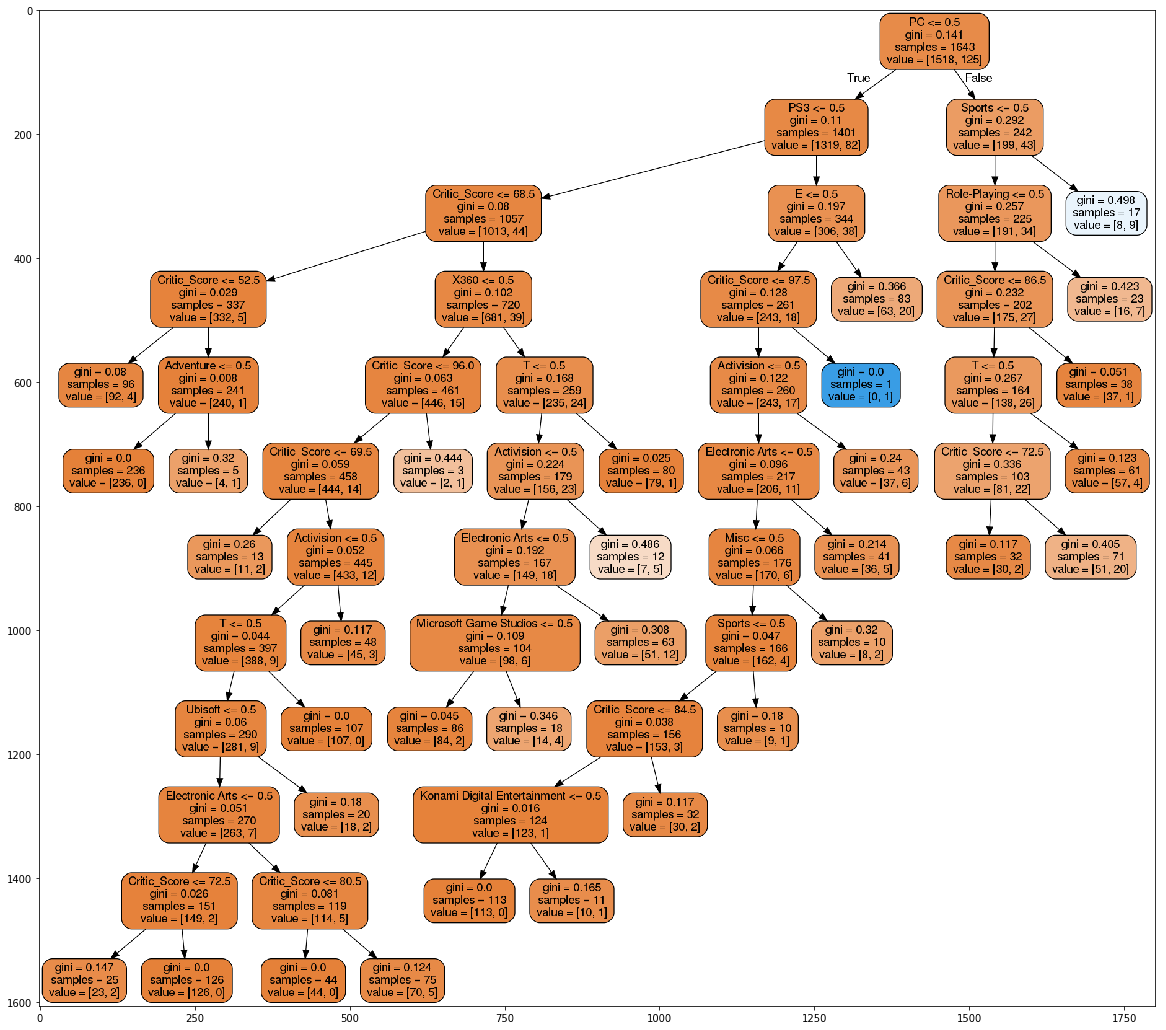

In [13]:
show_tree(dt12, features, 'arbol_normal.png')

Árbol Oversampled:

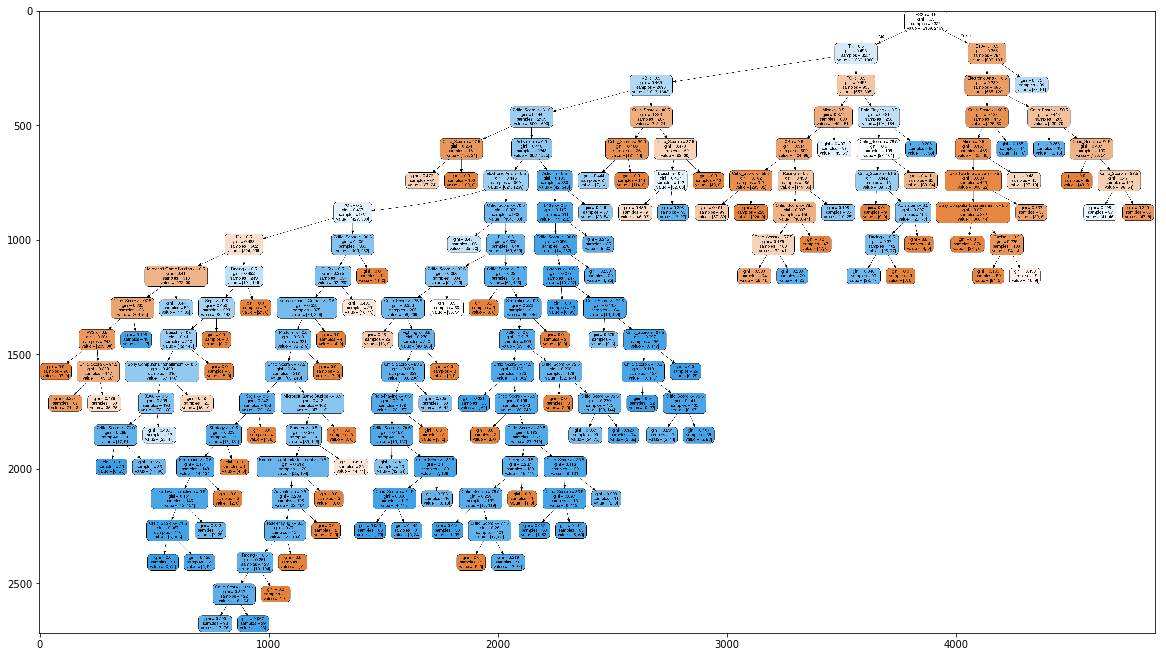

In [14]:
show_tree(dt13, features, 'arbol_oversampled.png')

Árbol Subsampled:

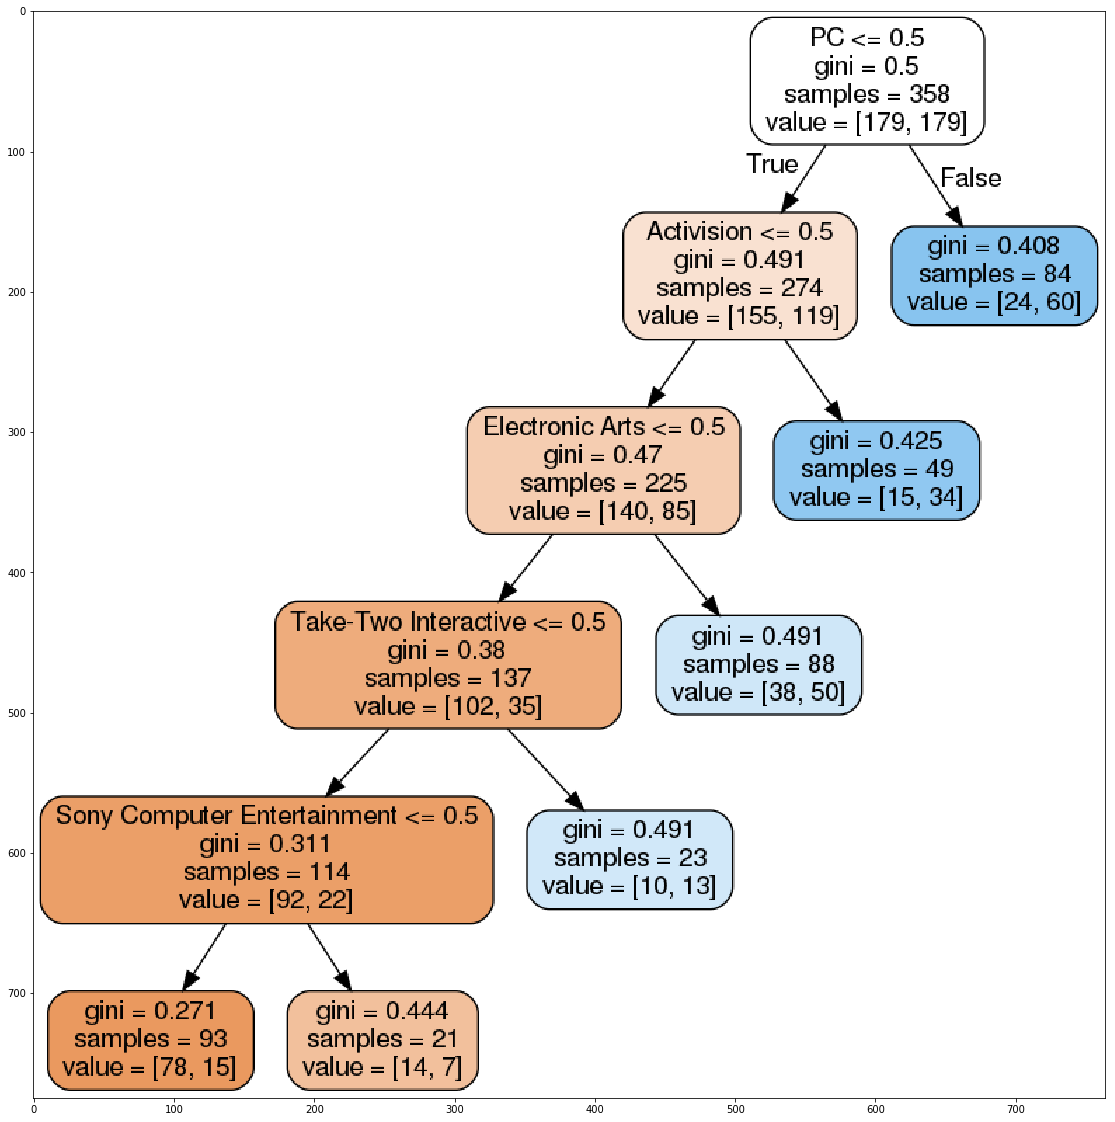

In [15]:
show_tree(dt14, features, 'arbol_subsampled.png')

Árbol con Oversampling y Subsampling:

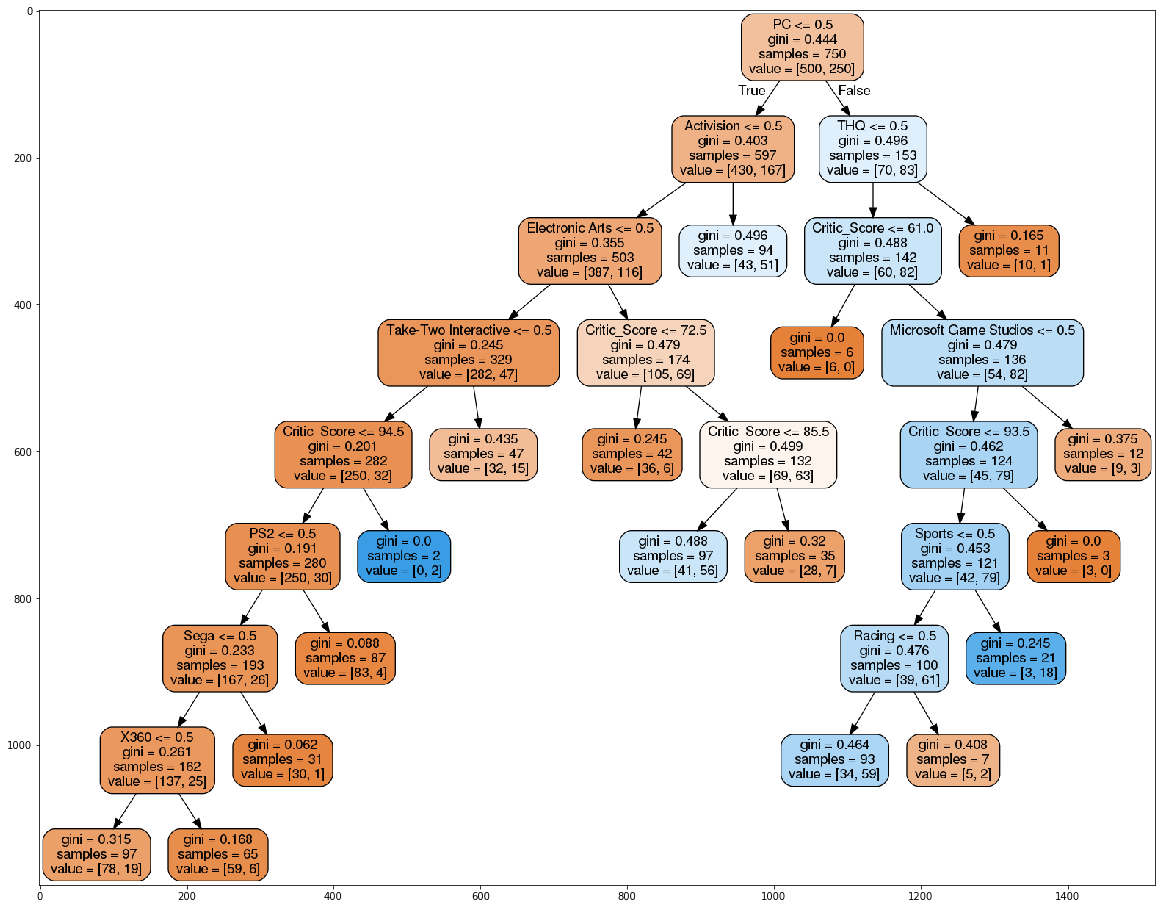

In [16]:
show_tree(dt15, features, 'arbol_master.png')

## Random Forest
Se aplica Random Forest para obtener los atributos que tienen mayor importancia en los árboles de decisión.

In [17]:
clf6 = RandomForestClassifier(n_estimators= 1000,max_depth=100, random_state=0)
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]
clf6.fit(X_train, y_train)
import operator
mi_lista_de_tuplas = []
for i in range(33):
    tupla = (header[i],clf6.feature_importances_[i])
    mi_lista_de_tuplas.append(tupla)
mi_lista_de_tuplas.sort(key=operator.itemgetter(1), reverse=True)
for i in range(33):
    print(mi_lista_de_tuplas[i])

('Critic_Score', 0.5070531122026577)
('Activision', 0.03681654267235462)
('Electronic Arts', 0.030297683820807324)
('Action', 0.029112611679414497)
('PC', 0.02900177839889974)
('PS3', 0.026909973379297264)
('E', 0.025389261256899092)
('X360', 0.024819455080887346)
('T', 0.024626325681830187)
('PS2', 0.022542885044092985)
('XB', 0.022203896591153786)
('Sports', 0.021835045287772283)
('Racing', 0.019542582376023108)
('M', 0.019352541576867145)
('E10+', 0.017936777657350828)
('Take-Two Interactive', 0.01749881997094527)
('Shooter', 0.01637380877820795)
('Role-Playing', 0.014041085759131525)
('Ubisoft', 0.011250114016798185)
('Misc', 0.010742558009933787)
('Sony Computer Entertainment', 0.009948490999778603)
('THQ', 0.00959442054512633)
('Konami Digital Entertainment', 0.008400115651203001)
('Sega', 0.007821454136167688)
('Microsoft Game Studios', 0.007225085653396305)
('Simulation', 0.006703503139714737)
('Platform', 0.00627865504167114)
('Strategy', 0.005776630618319868)
('Adventure', 0.

# Reglas de Asociación
Se aplicaron técnicas de reglas de asociación. Para esto primero se hace un preprocesamiento de los datos, en donde, por ejemplo, se definen las clases respecto a la cantidad de ventas (Muchisimas, Muchas, Bastante, Intermedio, Pocas, Muypocas):

Después de generar estos archivos .csv se aplican las reglas de asociación:

Con esto se obtienen los siguientes resultados:
> Usando todos los datos se obtienen resultados que no aportan mucha información, como por ejemplo:
- {Muchas ventas Regionales} => {Muchas ventas globales}
- {Konami,  muy pocas ventas en EU} => {Konami Digital Entertainment}

> Considerando solo las ventas globales y no las regionales suceden cosas parecidas:
- {muy pocas Ventas globales,  Ubisoft Montreal} => {Ubisoft}

> Sin considerar las ventas tampoco se obtienen resultados muy significativos:
- {EA Canada, Puntajes usuarios alto} => {Electronic Arts}

> Sin el género, la plataforma ni el año:
- {Konami,  n° críticas usuarios muy bajo} => {Konami Digital Entertainment}

> Sin el número de críticas se obtienen resultados un poco más interesantes, como por ejemplo:
- {Nintendo,  Puntajes Críticos muy alto} => {Puntajes usuarios muy alto}

> Lo cual a primera vista podría indicar que los juegos de Nintendo tienden a no ser un fiasco, sin embargo, esto es un error pues ambos puntajes podrían ser muy altos según los criterios definidos y aún así tener una diferencia de 2 puntos.

> Al eliminar el desarrollador sucede algo parecido al caso anterior, aunque en el caso de Electronic Arts se observa que puntaje de usuarios alto suele estar relacionado con puntaje de críticos aún más alto:
- {Electronic Arts, Puntajes usuarios alto} => {Puntajes Críticos muy alto}
- {Nintendo, Puntajes Críticos muy alto} => {Puntajes usuarios muy alto}

> Con el desarrollador pero sin publicador no se observan cambios significativos.

> Al considerar el atributo Is_Fiasco se obtienen los resultados más interesantes, en los cuales se sugiere que el publicador puede estar muy relacionado con la clasificación del videojuego:
- {TRUE} => {Activision}
- {TRUE} => {Electronic Arts}
- {Namco Bandai Games} => {FALSE}
- {THQ} => {FALSE}